We want to understand whether there is a generalization gap between the source and target. Such gap exists across countries, but we are not sure whether it exists across clusters.

In [1]:
from dataset import *
from train import *


In [2]:
import os
import pandas as pd

import collections

import torch
import torch.optim as optim


from sklearn.cluster import KMeans

In [237]:
n_cluster = 10
epochs = 10
lr = 0.01 

## Clustering

In [238]:
country_location_df = pd.read_csv("country_location.csv", index_col=0)

In [239]:
country_location_df.head()

,country,count,latitude,longitude
0,Sverige,855,59.674971,14.520858
1,France,5252,46.603354,1.888334
2,Eesti,82,58.752378,25.331908
3,Éire / Ireland,413,52.865196,-7.979460
4,Latvija,148,56.840649,24.753764


In [240]:
country_location = country_location_df.to_dict("list")

In [241]:
kmeans = KMeans(n_clusters= n_cluster, n_init=10, random_state=0, max_iter=1000)
X = country_location_df.loc[:, ["longitude", "latitude"]]
weights = country_location["count"]

kmeans.fit(X, sample_weight = weights)

country_location_df["cluster"] = kmeans.predict(X, sample_weight = weights)
clusters = dict.fromkeys(list(range(n_cluster)), 0)
for _, r in country_location_df.iterrows():
    clusters[r["cluster"]] += r["count"]
clusters

{0: 2619,
 1: 2469,
 2: 5756,
 3: 50,
 4: 750,
 5: 421,
 6: 3387,
 7: 6658,
 8: 2511,
 9: 2355}

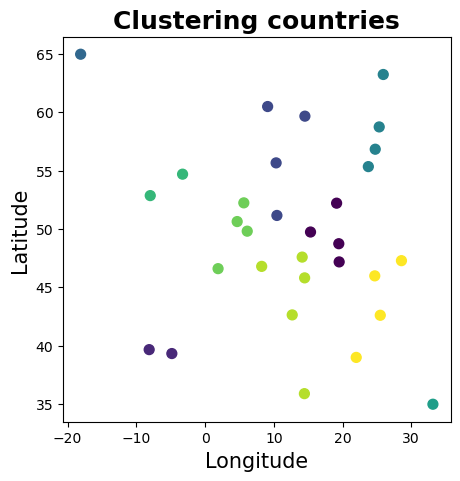

In [242]:
import matplotlib.pyplot as plt

plt.style.use('default')
x = np.array(country_location_df['longitude'])
y = np.array(country_location_df['latitude'])
plt.figure(figsize = (5, 5))
plt.scatter(x, y, s = 50, #cmap='viridis',
            c = country_location_df["cluster"],
            label = 'Spend in Organic Products')
plt.title('Clustering countries', fontsize = 18, fontweight = 'bold')
plt.xlabel('Longitude', fontsize = 15)
plt.ylabel('Latitude', fontsize = 15)

centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5);

# Test the gap

## Load image data

In [243]:
EuroSat_Type = 'ALL'
if EuroSat_Type == 'RGB':
  data_folder = '/content/sample_data/'
  #root = os.path.join(data_folder, '2750/')
  root = '2750/'
  download_ON = os.path.exists(root)

  if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
    os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
    !unzip EuroSAT.zip
    download_ON = True
elif EuroSat_Type == 'ALL':
    root = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'
    download_ON = os.path.exists(root)
    if not download_ON:
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip') #All bands
      !unzip EuroSATallBands.zip
      download_ON = True

In [244]:
geo_df = pd.read_csv("metadata.csv")
geo_df = pd.merge(geo_df, country_location_df.loc[:, ["country", "cluster"]], on='country', how='inner')
geo_df.to_csv("metadata_clustered" + str(n_cluster) + ".csv")


In [245]:
data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform = None, extensions = 'tif')
labels = [v[1] for (i, v) in enumerate(data)]

In [220]:
labels = [v[1] for (i, v) in enumerate(data)]

In [221]:
def prepare_input_data(geo_df, target_task, group_by = "country",
                       labels = None, 
                       train_size = 320, test_size = 320, target_size = 1600):
    
    geo_dict = geo_df.to_dict()
    groups = list(set(geo_dict[group_by].values()))
    groups = [x for x in groups if str(x) != "nan"]
    id_groups = dict.fromkeys(groups)
    for k in id_groups.keys():
        id_groups[k] = [v for (i, v) in enumerate(geo_dict["id"]) if geo_dict[group_by][i] == k]

    # create a dictionary for input data
    
    input_data = {
        "source_task": list(set(id_groups.keys()) - set([target_task])),
        "target_task": target_task
    }

    
    # all data, both source and target
    
    input_data["data_dict"] = {}
    for k in geo_dict.keys():
        input_data["data_dict"][k] = [geo_dict[k][i] for (i, v) in enumerate(geo_dict[group_by].values()) if str(v) != "nan"]


        
    # split indices for source and target
    
    input_data["idx_source"] = [i for (i, v) in enumerate(input_data["data_dict"][group_by]) if v != input_data["target_task"]]
    input_data["idx_target"] = [i for (i, v) in enumerate(input_data["data_dict"][group_by]) if v == input_data["target_task"]]

    target_labels = list(set([labels[i] for i in input_data["idx_target"]]))
    input_data["target_labels"] = target_labels
    
    # rewrite the source indices, because some countries may have non-overlapping labels with the target task
    input_data["idx_source"] = [i for i in input_data["idx_source"] if labels[i] in target_labels]
    
    # For source data, create a dictionary to record the countries
    input_data["source_dict"] = {}
    
    for k in geo_dict.keys():
        input_data["source_dict"][k] = [input_data["data_dict"][k][i] for i in idx_source]
    
    
   
    input_data["source_task"] = list(set(input_data["source_dict"][group_by]))
    
    input_data["source_labels"] = list(set([labels[i] for i in input_data["idx_source"]]))
    # resample the target to make the number of samples is fixed
    
   # if len(input_data["idx_target"]) >= target_size:
       # input_data["idx_target"] = random.sample(input_data["idx_target"], k = target_size)
    #else:
       # input_data["idx_target"] = random.choices(input_data["idx_target"], k = target_size)
        
    
    # split the target data into train / validation / test sets
    
    y_target = [labels[i] for i in input_data["idx_target"]]
    input_data["idx_train"], idx_rest, _, y_rest = train_test_split(input_data["idx_target"],
                                                              y_target,
                                                             train_size = target_size,
                                                              random_state = 0, shuffle = True)
    
    input_data["idx_val"], input_data["idx_test"], _, _ = train_test_split(idx_rest,
                                                              y_rest,
                                                              train_size = train_size,
                                                              test_size = test_size,
                                                              random_state = 0, shuffle = True)
    
    
    input_data["target_size"] = target_size
    return input_data



In [222]:
input_data = prepare_input_data(geo_df, target_task = 0, group_by = "cluster", 
                                labels = labels,
                               train_size = 320, test_size = 160, target_size = 320)

## set up training

In [223]:
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

target_val_loader =  torch.utils.data.DataLoader(torch.utils.data.Subset(data, input_data["idx_val"]), 
                                              batch_size = 16, shuffle = True, num_workers = 0)
target_train_loader =  torch.utils.data.DataLoader(torch.utils.data.Subset(data, input_data["idx_train"]), 
                                                  batch_size = 16, shuffle = True, num_workers = 0)
target_test_loader =  torch.utils.data.DataLoader(torch.utils.data.Subset(data, input_data["idx_test"]), 
                                                  batch_size = 16, shuffle = True, num_workers = 0)




In [224]:
random_indicies = random.sample(input_data["idx_source"], 320)
random_source_loader =  torch.utils.data.DataLoader(torch.utils.data.Subset(data,
                                                                            random_indicies), 
                                                  batch_size = 16, shuffle = True, num_workers = 0)


In [225]:
for indices in input_data["idx_train"], input_data["idx_val"], input_data["idx_test"], random_indicies:
    current_labels = [data.samples[i][1] for i in indices]
    print(collections.Counter(current_labels).values())

dict_values([115, 28, 46, 19, 36, 29, 47])
dict_values([53, 26, 45, 104, 25, 37, 30])
dict_values([29, 16, 24, 13, 52, 18, 8])
dict_values([63, 13, 56, 46, 53, 49, 40])


In [226]:
criteria = torch.nn.CrossEntropyLoss()
net = Load_model()
if torch.cuda.is_available():
    net=net.cuda()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

Model Loaded


## On target train

In [227]:
def train(net, train_, val_, criterion, optimizer, epochs=None, scheduler=None, weights=None, save_epoch = 10,
plot = False):
    t0 = time.time()
    losses=[]; acc=[]; mean_losses=[]; 
    train_acc = []; val_acc=[]; train_losses = []
    iter_ = 0

    for e in range(1, epochs + 1):
        print('e=',e,'{} seconds'.format(time.time() - t0))

        net.train()
        y_train = []; yhat_train = []
        for batch_idx, (data, target) in enumerate(train_):

            if torch.cuda.is_available():
                data, target =  cus_aug(Variable(data.cuda())), Variable(target.cuda())
            else:
                data, target =  cus_aug(Variable(data)), Variable(target)

            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses = np.append(losses,loss.item())
            mean_losses = np.append(mean_losses, np.mean(losses[max(0,iter_-100):iter_]))

            clear_output()
            pred = output.data.cpu().numpy()#[0]
            pred = sigmoid(pred)# (16, 10)
            gt = target.data.cpu().numpy()#[0]
            acc = np.append(acc, accuracy(gt, pred))

            # visualize ---
            if iter_ % 10 == 0: #printing after 600 epochs
                print('Iteration Number',iter_,'{} seconds'.format(time.time() - t0))
                t0 = time.time()
                pred = output.data.cpu().numpy()#[0]
                pred=sigmoid(pred)
                gt = target.data.cpu().numpy()#[0]
                acc = np.append(acc,accuracy(gt,pred))
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
                    e, epochs, batch_idx, len(train_),
                    100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))
                plt.plot(mean_losses) and plt.show()
                val_acc = np.append(val_acc,validation(net, val_)[0])
                print('validation accuracy : {}'.format(val_acc[-1]))
                plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                plt.legend() and plt.show()
                #print(mylabels[np.where(gt[1,:])[0]])
                
            # ---
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
            e, epochs, batch_idx, len(train_),
        100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))

            iter_ += 1

            del(data, target, loss)

            # save predictions at the last epoch
            if e == epochs:
                y_train = y_train + np.asarray(gt).tolist()

                _, predictions = torch.max(torch.from_numpy(pred), 1)
                yhat_train = yhat_train + np.asarray(predictions).tolist()
            
            

        train_losses = np.append(train_losses, np.mean(losses))
        train_acc = np.append(train_acc, np.mean(acc))
        if scheduler is not None:
           scheduler.step()
        #if e % save_epoch == 0:
            #torch.save(net.state_dict(), '.\Eurosat{}'.format(e))

        # make predictions on the validation set
        val_acc_, y_val, yhat_val = validation(net, val_)
        val_acc = np.append(val_acc, val_acc_)
        
        train_dict = {"y_train": y_train,
                 "yhat_train": yhat_train}
        val_dict = {"y_val": y_val,
               "yhat_val": yhat_val}

    
                
    return net, val_acc, train_acc, train_losses, train_dict, val_dict



In [228]:
net = Load_model()
net, val_acc, train_acc, _, _, _ = train(net, target_test_loader, target_test_loader, criteria, optimizer, epochs, scheduler)

Train (epoch 10/10) [9/10 (90%)]	Loss: 2.142477	Accuracy: 0.0625	Learning Rate:0.01


In [229]:
net = Load_model()
net, val_acc, train_acc, _, _, _ = train(net, target_train_loader, target_test_loader, criteria, optimizer, epochs, scheduler)

Train (epoch 10/10) [19/20 (95%)]	Loss: 2.363656	Accuracy: 0.0625	Learning Rate:0.01


In [230]:
val_acc[-1]       

0.1125

## On random source

In [231]:
net_random = Load_model()
net_random, val_acc, train_acc, _, _, _  = train(net, random_source_loader, target_test_loader, criteria, optimizer, epochs, scheduler)
#torch.save(net_random.state_dict(), output_path + "random_source" )

Train (epoch 10/10) [19/20 (95%)]	Loss: 2.395190	Accuracy: 0.1875	Learning Rate:0.01


In [232]:
val_acc[-1]

0.09375